## Demo 4: HKR multiclass and fooling
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/deel-lip/blob/master/docs/notebooks/demo4.ipynb)

This notebook will show how to train a lispchitz network in a multiclass setup.
The HKR is extended to multiclass using a one-vs all setup. It will go through
the process of designing and training the network. It will also show how to create robustness certificates from the output of the network. Finally these
certificates will be checked by attacking the network. 

### installation

First, we install the required libraries. `Foolbox` will allow to perform adversarial attacks on the trained network.

In [1]:
# pip install deel-lip foolbox -qqq

In [2]:
from deel.lip.layers import (
    SpectralDense,
    SpectralConv2D,
    ScaledL2NormPooling2D,
    ScaledAveragePooling2D,
    FrobeniusDense,
)
from deel.lip.model import Sequential
from deel.lip.activations import GroupSort, FullSort
from deel.lip.losses import MulticlassHKR, MulticlassKR
from deel.lip.callbacks import CondenseCallback
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

2021-09-09 14:03:36.448213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


For this example, the dataset `fashion_mnist` will be used. In order to keep things simple, no data augmentation will be performed.

In [3]:
# load data
(x_train, y_train_ord), (x_test, y_test_ord) = fashion_mnist.load_data()
# standardize and reshape the data
x_train = np.expand_dims(x_train, -1) / 255
x_test = np.expand_dims(x_test, -1) / 255
# one hot encode the labels
y_train = to_categorical(y_train_ord)
y_test = to_categorical(y_test_ord)

Let's build the network. 

### the architecture

The original one vs all setup would require 10 different networks ( 1 per class ), however, in practice we use a network with
a common body and 10 1-lipschitz heads. Experiments have shown that this setup don't affect the network performance. In order to ease the creation of such network, `FrobeniusDense` layer has a parameter for this:  whenr `disjoint_neurons=True` it act as the stacking of 10 single neurons head. Note that, altough each head is a 1-lipschitz function the overall network is not 1-lipschitz (Concatenation is not 1-lipschitz). We will see later how this affects the certficate creation.

### the loss

The multiclass loss can be found in `HKR_multiclass_loss`. The loss has two params: `alpha` and `min_margin`. Decreasing `alpha` and increasing `min_margin` improve robustness (at the cost of accuracy). note also in the case of lipschitz networks, more robustness require more parameters. For more information see [our paper](https://arxiv.org/abs/2006.06520).

In this setup choosing `alpha=100`, `min_margin=.25` provide a good robustness without hurting the accuracy too much.

Finally the `KR_multiclass_loss()` indicate the robustness of the network ( proxy of the average certificate )


In [4]:
# Sequential (resp Model) from deel.model has the same properties as any lipschitz model.
# It act only as a container, with features specific to lipschitz
# functions (condensation, vanilla_exportation...)
model = Sequential(
    [
        Input(shape=x_train.shape[1:]),
        # Lipschitz layers preserve the API of their superclass ( here Conv2D )
        # an optional param is available: k_coef_lip which control the lipschitz
        # constant of the layer
        SpectralConv2D(
            filters=16,
            kernel_size=(3, 3),
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
        # usual pooling layer are implemented (avg, max...), but new layers are also available
      ScaledL2NormPooling2D(pool_size=(2, 2), data_format="channels_last"),
        SpectralConv2D(
            filters=32,
            kernel_size=(3, 3),
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
      ScaledL2NormPooling2D(pool_size=(2, 2), data_format="channels_last"),
        # our layers are fully interoperable with existing keras layers
        Flatten(),
        SpectralDense(
            64,
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
        FrobeniusDense(
            y_train.shape[-1], activation=None, use_bias=False, kernel_initializer="orthogonal"
        ),
    ],
    # similary model has a parameter to set the lipschitz constant
    # to set automatically the constant of each layer
    k_coef_lip=1.0,
    name="hkr_model",
)

# HKR (Hinge-Krantorovich-Rubinstein) optimize robustness along with accuracy
model.compile(
    # decreasing alpha and increasing min_margin improve robustness (at the cost of accuracy)
    # note also in the case of lipschitz networks, more robustness require more parameters.
    loss=MulticlassHKR(alpha=100, min_margin=.25),
    optimizer=Adam(1e-4),
    metrics=["accuracy", MulticlassKR()],
)

model.summary()

2021-09-09 14:03:38.719310: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-09 14:03:38.719800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-09 14:03:38.750242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-09 14:03:38.750491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-09-09 14:03:38.750504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-09 14:03:38.751559: I tensorflow/stream_executor/platform/def

Model: "hkr_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_conv2d (SpectralCon (None, 28, 28, 16)        321       
_________________________________________________________________
scaled_l2norm_pooling2d (Sca (None, 14, 14, 16)        0         
_________________________________________________________________
spectral_conv2d_1 (SpectralC (None, 14, 14, 32)        9281      
_________________________________________________________________
scaled_l2norm_pooling2d_1 (S (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
spectral_dense (SpectralDens (None, 64)                200833    
_________________________________________________________________
frobenius_dense (FrobeniusDe (None, 10)                12

/home/thibaut.boissin/projects/repo_github/deel-lip/deel/lip/model.py:56: UserWarning: Sequential model contains a layer wich is not a Lipschitz layer: flatten
  layer.name


### notes about constraint enforcement

There are currently 3 way to enforce a constraint in a network:
1. regularization
2. weight reparametrization
3. weight projection

The first one don't provide the required garanties, this is why `deel-lip` focuses on the later two. Weight reparametrization is done directly in the layers (parameter `niter_bjorck`) this trick allow to perform arbitrary gradient updates without breaking the constraint. However this is done in the graph, increasing ressources consumption. The last method project the weights between each batch, ensuring the constraint at an more affordable computational cost. It can be done in `deel-lip` using the `CondenseCallback`. The main problem with this method is a reduced efficiency of each update.

As a rule of thumb, when reparametrization is used alone, setting `niter_bjorck` to at least 15 is advised. However when combined with weight projection, this setting can be lowered greatly.

In [5]:
# fit the model
model.fit(
    x_train,
    y_train,
    batch_size=4096,
    epochs=100,
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
)

2021-09-09 14:03:40.083840: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-09 14:03:40.100871: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/100


2021-09-09 14:03:42.102055: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-09 14:03:42.320388: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-09 14:03:42.331382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


15/15 [==============================] - 5s 117ms/step - loss: 41.2174 - accuracy: 0.1382 - MulticlassKR: 0.0467 - val_loss: 29.5743 - val_accuracy: 0.2798 - val_MulticlassKR: 0.1810
Epoch 2/100
15/15 [==============================] - 1s 81ms/step - loss: 25.3826 - accuracy: 0.4441 - MulticlassKR: 0.2389 - val_loss: 19.8280 - val_accuracy: 0.5547 - val_MulticlassKR: 0.3549
Epoch 3/100
15/15 [==============================] - 1s 81ms/step - loss: 18.3231 - accuracy: 0.5899 - MulticlassKR: 0.4017 - val_loss: 16.0346 - val_accuracy: 0.6183 - val_MulticlassKR: 0.4835
Epoch 4/100
15/15 [==============================] - 1s 81ms/step - loss: 15.0896 - accuracy: 0.6402 - MulticlassKR: 0.5135 - val_loss: 13.9297 - val_accuracy: 0.6470 - val_MulticlassKR: 0.5607
Epoch 5/100
15/15 [==============================] - 1s 81ms/step - loss: 13.2237 - accuracy: 0.6814 - MulticlassKR: 0.5821 - val_loss: 12.5531 - val_accuracy: 0.6814 - val_MulticlassKR: 0.6186
Epoch 6/100
15/15 [======================

15/15 [==============================] - 1s 80ms/step - loss: 5.5395 - accuracy: 0.8245 - MulticlassKR: 1.3460 - val_loss: 5.8039 - val_accuracy: 0.8189 - val_MulticlassKR: 1.3538
Epoch 44/100
15/15 [==============================] - 1s 81ms/step - loss: 5.4303 - accuracy: 0.8249 - MulticlassKR: 1.3593 - val_loss: 5.7421 - val_accuracy: 0.8189 - val_MulticlassKR: 1.3669
Epoch 45/100
15/15 [==============================] - 1s 80ms/step - loss: 5.3844 - accuracy: 0.8268 - MulticlassKR: 1.3762 - val_loss: 5.6846 - val_accuracy: 0.8217 - val_MulticlassKR: 1.3765
Epoch 46/100
15/15 [==============================] - 1s 80ms/step - loss: 5.3307 - accuracy: 0.8281 - MulticlassKR: 1.3873 - val_loss: 5.6413 - val_accuracy: 0.8234 - val_MulticlassKR: 1.3881
Epoch 47/100
15/15 [==============================] - 1s 80ms/step - loss: 5.3788 - accuracy: 0.8258 - MulticlassKR: 1.3938 - val_loss: 5.6087 - val_accuracy: 0.8214 - val_MulticlassKR: 1.3971
Epoch 48/100
15/15 [============================

15/15 [==============================] - 1s 80ms/step - loss: 4.1970 - accuracy: 0.8497 - MulticlassKR: 1.7701 - val_loss: 4.5760 - val_accuracy: 0.8405 - val_MulticlassKR: 1.7660
Epoch 86/100
15/15 [==============================] - 1s 80ms/step - loss: 4.1455 - accuracy: 0.8507 - MulticlassKR: 1.7759 - val_loss: 4.5417 - val_accuracy: 0.8425 - val_MulticlassKR: 1.7734
Epoch 87/100
15/15 [==============================] - 1s 80ms/step - loss: 4.1810 - accuracy: 0.8506 - MulticlassKR: 1.7823 - val_loss: 4.5125 - val_accuracy: 0.8417 - val_MulticlassKR: 1.7786
Epoch 88/100
15/15 [==============================] - 1s 80ms/step - loss: 4.1159 - accuracy: 0.8518 - MulticlassKR: 1.7922 - val_loss: 4.5125 - val_accuracy: 0.8391 - val_MulticlassKR: 1.7913
Epoch 89/100
15/15 [==============================] - 1s 81ms/step - loss: 4.1807 - accuracy: 0.8500 - MulticlassKR: 1.7990 - val_loss: 4.4882 - val_accuracy: 0.8402 - val_MulticlassKR: 1.7938
Epoch 90/100
15/15 [============================

### model exportation

Once training is finished, the model can be optimized for inference by using the `vanilla_export()` method.

In [6]:
# once training is finished you can convert
# SpectralDense layers into Dense layers and SpectralConv2D into Conv2D
# which optimize performance for inference
vanilla_model = model.vanilla_export()

### certificates generation and adversarial attacks

In [7]:
import foolbox as fb
from tensorflow import convert_to_tensor
import matplotlib.pyplot as plt
import tensorflow as tf

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-an1t4aqt because the default path (/home/thibaut.boissin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [8]:
# we will test it on 10 samples one of each class
nb_adv = 10

hkr_fmodel = fb.TensorFlowModel(vanilla_model, bounds=(0., 1.), device="/GPU:0")

In order to test the robustness of the model, the first correctly classified element of each class are selected.

In [9]:
# strategy: first
# we select a sample from each class.
images_list = []
labels_list = []
# select only a few element from the test set
selected=np.random.choice(len(y_test_ord), 500)
sub_y_test_ord = y_test_ord[:300]
sub_x_test = x_test[:300]
# drop misclassified elements
misclassified_mask = tf.equal(tf.argmax(vanilla_model.predict(sub_x_test), axis=-1), sub_y_test_ord)
sub_x_test = sub_x_test[misclassified_mask]
sub_y_test_ord = sub_y_test_ord[misclassified_mask]
# now we will build a list with input image for each element of the matrix
for i in range(10):
  # select the first element of the ith label
  label_mask = [sub_y_test_ord==i]
  x = sub_x_test[label_mask][0]
  y = sub_y_test_ord[label_mask][0]
  # convert it to tensor for use with foolbox
  images = convert_to_tensor(x.astype("float32"), dtype="float32")
  labels = convert_to_tensor(y, dtype="int64")
  # repeat the input 10 times, one per misclassification target
  images_list.append(images)
  labels_list.append(labels)
images = convert_to_tensor(images_list)
labels = convert_to_tensor(labels_list)

/home/thibaut.boissin/envs/deel-lip_github/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/thibaut.boissin/envs/deel-lip_github/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In order to build a certficate, we take for each sample the top 2 output and apply this formula:
$$ \epsilon \geq \frac{\text{top}_1 - \text{top}_2}{2} $$
Where epsilon is the robustness radius for the considered sample.

In [10]:
values, classes = tf.math.top_k(hkr_fmodel(images), k=2)
certificates = (values[:, 0] - values[:, 1]) / 2
certificates

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.25511226, 1.0321686 , 0.34624586, 0.5743104 , 0.12979731,
       0.19581676, 0.08184442, 0.34386343, 0.68743587, 0.12055641],
      dtype=float32)>

now we will attack the model to check if the certificates are respected. In this setup `L2CarliniWagnerAttack` is used but in practice as these kind of networks are gradient norm preserving, other attacks gives very similar results.

In [11]:
attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=6, steps=8000)
imgs, advs, success = attack(hkr_fmodel, images, labels, epsilons=None)
dist_to_adv = np.sqrt(np.sum(np.square(images - advs), axis=(1,2,3)))
dist_to_adv

array([1.3944995 , 3.5208094 , 1.6824133 , 1.9192038 , 0.5746496 ,
       0.7780392 , 0.39687884, 1.1619285 , 2.367604  , 0.48984095],
      dtype=float32)

As we can see the certificate are respected.

In [12]:
tf.assert_less(certificates, dist_to_adv)

Finally we can take a visual look at the obtained examples.
We first start with utility functions for display.

In [13]:
class_mapping = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot",
}

In [14]:
def adversarial_viz(model, images, advs, class_mapping):
  """
  This functions shows for each sample: 
  - the original image
  - the adversarial image
  - the difference map
  - the certificate and the observed distance to adversarial 
  """
  scale = 1.5
  kwargs={}
  nb_imgs = images.shape[0]
  # compute certificates
  values, classes = tf.math.top_k(model(images), k=2)
  certificates = (values[:, 0] - values[:, 1]) / 2
  # compute difference distance to adversarial
  dist_to_adv = np.sqrt(np.sum(np.square(images - advs), axis=(1,2,3)))
  # find classes labels for imgs and advs
  orig_classes = [class_mapping[i] for i in tf.argmax(model(images), axis=-1).numpy()]
  advs_classes = [class_mapping[i] for i in tf.argmax(model(advs), axis=-1).numpy()]
  # compute differences maps
  if images.shape[-1] != 3:
    diff_pos = np.clip(advs - images, 0, 1.)
    diff_neg = np.clip(images - advs, 0, 1.)
    diff_map = np.concatenate([diff_neg, diff_pos, np.zeros_like(diff_neg)], axis=-1)
  else:
    diff_map = np.abs(advs - images)
  # expands image to be displayed
  if images.shape[-1] != 3:
    images = np.repeat(images, 3, -1)
  if advs.shape[-1] != 3:
    advs = np.repeat(advs, 3, -1)
  # create plot
  figsize = (3 * scale, nb_imgs * scale)
  fig, axes = plt.subplots(
    ncols=3,
    nrows=nb_imgs,
    figsize=figsize,
    squeeze=False,
    constrained_layout=True,
    **kwargs,
  )
  for i in range(nb_imgs):
    ax = axes[i][0]
    ax.set_title(orig_classes[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.imshow(images[i])
    ax = axes[i][1]
    ax.set_title(advs_classes[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.imshow(advs[i])
    ax = axes[i][2]
    ax.set_title(f"certif: {certificates[i]:.2f}, obs: {dist_to_adv[i]:.2f}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.imshow(diff_map[i]/diff_map[i].max())

When looking at the adversarial examples we can see that the network has interresting properties:

#### predictability
by looking at the certificates, we can predict if the adversarial example will be close of not
#### disparity among classes
As we can see, the attacks are very efficent on similar classes (eg. T-shirt/top, and Shirt ). This denote that all classes are not made equal regarding robustness.
#### explainability
The network is more explainable: attacks can be used as counterfactuals.
We can tell that removing the inscription on a T-shirt turns it into a shirt makes sense. Non robust examples reveals that the network rely on textures rather on shapes to make it's decision.

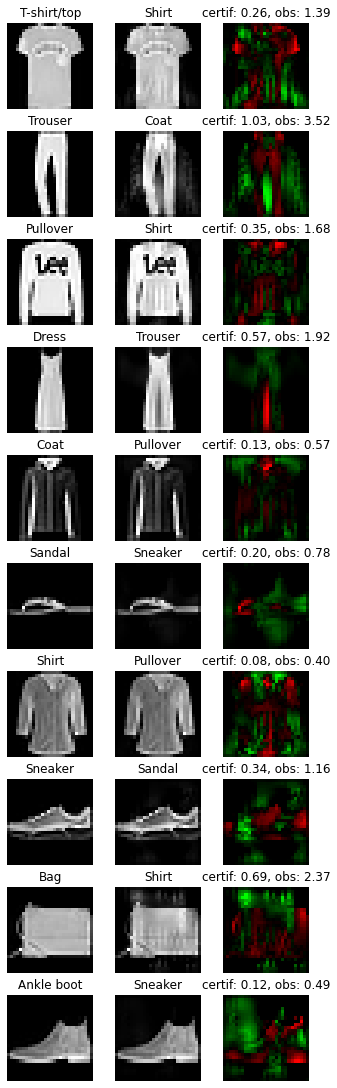

In [15]:
adversarial_viz(hkr_fmodel, images, advs, class_mapping)